## 分析A/B测试结果


## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)

<a id='intro'></a>
### 简介

了解电子商务网站运行的 A/B 测试的结果，通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。


<a id='probability'></a>
#### I - 概率

先导入库

In [72]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  

a. 导入数据集，并在这里查看前几行：

In [127]:
df=pd.read_csv('data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 使用下面的单元格来查找数据集中的行数。

In [128]:
df.shape

(294478, 5)

c. 数据集中独立用户的数量。

In [129]:
df['user_id'].nunique()

290584

d. 用户转化的比例。

In [130]:
df[df['converted']==1].user_id.nunique()/df['user_id'].nunique()

0.12104245244060237

e.  `new_page` 与 `treatment` 不一致的次数。

方法一：

In [131]:
df_control=df[df['group']=='control']
#df_control[df_control['landing_page']=='old_page'].count()
df_control.groupby('landing_page').count()

,user_id,timestamp,group,converted
landing_page,,,,
new_page,1928,1928,1928,1928
old_page,145274,145274,145274,145274


In [132]:
df_treatment=df[df['group']=='treatment']
df_treatment.groupby('landing_page').count()

,user_id,timestamp,group,converted
landing_page,,,,
new_page,145311,145311,145311,145311
old_page,1965,1965,1965,1965


方法二：

In [133]:
treatment = df['group'] == 'treatment'
new_page  = df['landing_page'] == 'new_page'
mismatch  = treatment != new_page
mismatch.sum()

3893


f. 查看是否有任何行存在缺失值

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


无缺失值

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面，选择删除这些不一致的行。

a. 创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

方法一：

In [135]:
#control不与 old_page一致的行为异常值，获取该行号和内容
df_control_nrow_value=df_control.loc[df['landing_page'] == 'new_page']
df_control_nrow=df_control_nrow_value.index.values
#print(df_control_nrow_value)
print(df_control_nrow)

[    22    240    490 ... 294200 294253 294331]


In [136]:
#删除control不与 old_page一致的行
df_control=df_control.drop(df_control_nrow)

In [137]:
#查看df_control是否删除完成
df_control.groupby('landing_page').count()

,user_id,timestamp,group,converted
landing_page,,,,
old_page,145274,145274,145274,145274


In [138]:
#treatment不与 new_page一致的行为异常值，获取该行号和内容
df_treatment_nrow_value=df_treatment.loc[df['landing_page'] == 'old_page']
df_treatment_nrow=df_treatment_nrow_value.index.values
#print(df_treatment_nrow_value)
print(df_treatment_nrow)

[   308    327    357 ... 293917 294014 294252]


In [139]:
#treatment不与 new_page一致的行
df_treatment=df_treatment.drop(df_treatment_nrow)

In [140]:
#查看df_treatment是否删除完成
df_treatment.groupby('landing_page').count()

,user_id,timestamp,group,converted
landing_page,,,,
new_page,145311,145311,145311,145311


In [141]:
#合并df_control与df_treatment
df2=df_control.append(df_treatment, ignore_index=True)
df2.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0


方法二：

In [142]:
df2 = df[~mismatch].copy() # 使用 ~mismatch 排除 mismatch 的各行

In [143]:
df2.tail(5)

,user_id,timestamp,group,landing_page,converted
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


In [144]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 使用 **df2** 进行如下测试 。

a.  查看**df2** 中有多少唯一的 **user_id**。

In [145]:
df2['user_id'].nunique(),df2['user_id'].count()

(290584, 290585)

i=int(0)
for i in range(290585):   
        id=df2.loc[i,'user_id']
        df2.loc[i,'user_id_count']=df2[df2['user_id']==id].count()[0]
        i=i+1

b.  **df2** 中有一个重复的 **user_id** 。

In [146]:
df2['IsDuplicated'] = df2['user_id'].duplicated()
df2.head()

,user_id,timestamp,group,landing_page,converted,IsDuplicated
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False


In [147]:
df2_id_value=df2.loc[df2['IsDuplicated']==True]
df__id_row=df2_id_value.index.values
#df2_id_value
df__id_row

array([2893], dtype=int64)

c. 这个重复的  **user_id** 的行信息。

In [148]:
df2[df2['IsDuplicated']==True]

,user_id,timestamp,group,landing_page,converted,IsDuplicated
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


d. 删除 **一个** 含有重复的 **user_id** 的行。

In [149]:
#将重复id行删除
df2=df2.drop(df__id_row)
df2=df2.reset_index()
#df2=df2.drop(df['IsDuplicated']==True)

In [150]:
df2.tail()

,index,user_id,timestamp,group,landing_page,converted,IsDuplicated
290579,294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,False
290580,294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,False
290581,294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,False
290582,294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,False
290583,294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0,False


In [151]:
df2.describe()

,index,user_id,converted
count,290584.000000,290584.000000,290584.000000
mean,147271.231929,788004.876222,0.119597
std,84998.147486,91224.735468,0.324490
min,0.000000,630000.000000,0.000000
25%,73669.750000,709034.750000,0.000000
50%,147301.500000,787995.500000,0.000000
75%,220877.250000,866956.250000,0.000000
max,294477.000000,945999.000000,1.000000


`4.` 在下面的单元格中，查看转化率。

a. 不管它们收到什么页面，单个用户的转化率：


In [152]:
df2['converted'].mean()

0.11959708724499628

b. 假定一个用户处于 `control` 组中，他的转化率：

In [153]:
df2.query("group=='control'")['converted'].mean()

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率：

In [154]:
df2.query("group=='treatment'")['converted'].mean()

0.11880806551510564

d. 一个用户收到新页面的概率：

In [155]:
df2.query("group=='treatment'").shape[0]/df2.shape[0]

0.5000619442226688

e. 使用这个问题的前两部分的结果，给出你的建议：

In [156]:
obs_diff=df2.query("group=='treatment'")['converted'].mean()-df2.query("group=='control'")['converted'].mean()
obs_diff

-0.0015782389853555567

将测试组与控制组的转化率相减为0.15%，相差没有太大，不能足够证明一个页面可以带来更多的转化

<a id='ab_test'></a>
### II - A/B 测试

`1.` 做出零假设与备择假设


$$H_0:  p_{new} -p_{old} \leq 0$$


$$H_1:  p_{new} -p_{old} > 0$$

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>

下面的单元格提供这个模拟的必要内容。<br><br>

a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** ：


In [157]:
#df2.query("group=='treatment'")['converted'].mean()
df2['converted'].mean()

0.11959708724499628

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** ： <br><br>

In [158]:
#df2.query("group=='control'")['converted'].mean()
df2['converted'].mean()

0.11959708724499628

c.  $n_{new}$ 是：

In [159]:
df2.query("group=='treatment'").shape[0]

145310

d.  $n_{old}$：

In [160]:
df2.query("group=='control'").shape[0]

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。

In [161]:
new_page_converted=np.random.choice([0,1],size=df2.query("group=='treatment'").shape[0],p=[1-df2['converted'].mean(),df2['converted'].mean()])
print(new_page_converted)
print(new_page_converted.mean())

[0 0 0 ... 1 0 0]
0.1198953960498245


f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [162]:
old_page_converted=np.random.choice([0,1],size=df2.query("group=='control'").shape[0],p=[1-df2['converted'].mean(),df2['converted'].mean()])
print(old_page_converted)
print(old_page_converted.mean())

[0 0 0 ... 0 0 0]
0.12042072222145739


g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [163]:
new_page_converted.mean()-old_page_converted.mean()

-0.0005253261716328811

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [164]:
p_diffs=[]
size_treatment=df2.query("group=='treatment'").shape[0]
size_control=df2.query("group=='control'").shape[0]
p_new=[1-df2['converted'].mean(),df2['converted'].mean()]
p_old=[1-df2['converted'].mean(),df2['converted'].mean()]
for _ in range(10000):
    new_page_converted=np.random.choice([0,1],size=size_treatment,p=p_new)
    old_page_converted=np.random.choice([0,1],size=size_control,p=p_old)
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

i. 绘制一个 **p_diffs** 直方图。

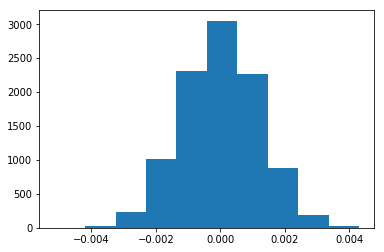

In [165]:
# Convert to numpy array
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

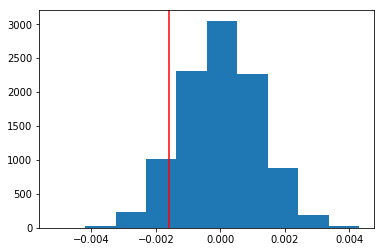

In [166]:
plt.hist(p_diffs);
plt.axvline(obs_diff, c='red');

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值：

In [177]:
(p_diffs > obs_diff).mean()

0.9093

In [ ]:
此值为p值，由于p值为0.9093，大于0.05，不拒绝原假设，即新页面的转化率小于旧页面的转化率

k. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [172]:
df2.head()

,index,user_id,timestamp,group,landing_page,converted,IsDuplicated
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False


In [173]:
df2.groupby('group').count()

,index,user_id,timestamp,landing_page,converted,IsDuplicated
group,,,,,,
control,145274,145274,145274,145274,145274,145274
treatment,145310,145310,145310,145310,145310,145310


In [174]:
import statsmodels.api as sm

df2_control=df2[df2['group'] == 'control']
df2_treatment=df2[df2['group'] == 'treatment']
convert_old = df2_control.query("converted==1").shape[0]
convert_new = df2_treatment.query("converted==1").shape[0]
n_old = df2[(df2['group'] == 'control')].shape[0]
n_new = df2[(df2['group'] == 'treatment')].shape[0]
print(convert_new,convert_old)
print(n_new,n_old)

17264 17489
145310 145274


l. 现在使用 `stats.proportions_ztest` 来计算检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [178]:
#z检验默认为双侧检验，此处为单侧检验
z_score, p_value = sm.stats.proportions_ztest([17264, 17489], [145310, 145274],alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [179]:
from scipy.stats import norm

norm.cdf(z_score)

# Tells us how significant our z-score is

norm.ppf(1-(0.05))
# Tells us what our critical value at 95% confidence is
norm.cdf(z_score),norm.ppf(1-(0.05))

(0.09494168724097551, 1.6448536269514722)

根据算出的 z-score 和 p-value，认为新旧页面的转化率有区别，与 j. 与 k. 中的结果一致。  
因为p=0.905>0.05，不拒绝原假设

<a id='regression'></a>
### III - 回归分析法之一

`1.`由于每行的值是转化或不转化 在之前的A / B测试中获得的结果也可以通过执行逻辑回归来获取。<br><br>


a. 使用 **statsmodels** 来拟合逻辑回归模型，以查看用户收到的不同页面是否存在显著的转化差异。首先，先为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [47]:
df2['intercept']=1
df2[['ab_npage','ab_page']]=pd.get_dummies(df2['group'])
df2.head()

,index,user_id,timestamp,group,landing_page,converted,IsDuplicated,intercept,ab_npage,ab_page
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,1,0
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,1,0
2,2,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,1,0
3,3,936923,2017-01-10 15:20:49.083499,control,old_page,0,False,1,1,0
4,4,719014,2017-01-17 01:48:29.539573,control,old_page,0,False,1,1,0



b. 使用 **statsmodels** 导入回归模型。 实例化该模型，并使用在 **a.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [48]:
log_mod=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


c. 为拟合模型的模型摘要。

In [49]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-07-09 19:43 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

d. 与ab_page相关的p值是 P>|z| 列下的 0.1899，与在 **II** 中发现的结果不同原因<br><br>  

与II中发现的结果不同是由于两者零假设，备择假设不同：  
 **Part II** 中的零假设和备择假设：
$$H_0:  p_{new} -p_{old} \leq 0$$


$$H_1:  p_{new} -p_{old} > 0$$
 **逻辑回归模型** 中的零假设和备择假设：
  $$H_0: p_{old} =p_{new} $$


$$H_1:  p_{old} \ne p_{new}$$

e. 考虑其他可能影响用户是否发生转化的因素。

f. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。导入 **countries.csv** 数据集，并将数据集合并在适当的行上。

In [50]:
df_countries=pd.read_csv('data/countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [51]:
#连接countries
df2=df2.join(df_countries.set_index('user_id'), on='user_id')

In [52]:
df2.head()

,index,user_id,timestamp,group,landing_page,converted,IsDuplicated,intercept,ab_npage,ab_page,country
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,1,0,US
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,1,0,US
2,2,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,1,0,US
3,3,936923,2017-01-10 15:20:49.083499,control,old_page,0,False,1,1,0,US
4,4,719014,2017-01-17 01:48:29.539573,control,old_page,0,False,1,1,0,US


In [53]:
#检查是否都能连接上
df2['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [54]:
#创建虚拟变量
df2[['CA','UK','US']]=pd.get_dummies(df2['country'])
df2.head(20)

,index,user_id,timestamp,group,landing_page,converted,IsDuplicated,intercept,ab_npage,ab_page,country,CA,UK,US
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,1,0,US,0,0,1
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,1,0,US,0,0,1
2,2,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,1,0,US,0,0,1
3,3,936923,2017-01-10 15:20:49.083499,control,old_page,0,False,1,1,0,US,0,0,1
4,4,719014,2017-01-17 01:48:29.539573,control,old_page,0,False,1,1,0,US,0,0,1
5,5,644214,2017-01-22 02:05:21.719434,control,old_page,1,False,1,1,0,US,0,0,1
6,6,847721,2017-01-17 14:01:00.090575,control,old_page,0,False,1,1,0,US,0,0,1
7,7,650559,2017-01-24 11:55:51.084801,control,old_page,0,False,1,1,0,CA,1,0,0
8,8,935734,2017-01-17 20:33:37.428378,control,old_page,0,False,1,1,0,US,0,0,1
9,9,746742,2017-01-23 11:38:29.592148,control,old_page,0,False,1,1,0,US,0,0,1


In [55]:
log_mod2=sm.Logit(df2['converted'],df2[['intercept','ab_page','US','CA']])
results2=log_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-07-09 19:43 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
==================================================================

"""

可看出，国家因素的添加，对转化率是无影响的：  
由于国家因素变量的 p 值均大于 0.05 的通常 alpha 水平，意味着不能拒绝斜率为 0 的零假设，即差异（影响）不具有统计学显著性

g. 在查看了国家与页面在转化率上的个体性因素，再查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

In [56]:
df2['new_CA'] = df2['ab_page'] * df2['CA']
df2['new_US'] = df2['ab_page'] * df2['US']

In [57]:
log_mod3=sm.Logit(df2['converted'],df2[['intercept','ab_page','US','CA','new_US','new_CA']])
results3=log_mod3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-07-09 19:43 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
new_US       -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
new_CA       -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
==================================================================

"""

可看出，交互变量的添加，对转化率是无影响的：  
由于两者交互变量的 p 值均大于 0.05 的通常 alpha 水平，意味着不能拒绝斜率为 0 的零假设，即差异（影响）不具有统计学显著性